# X ray segmentation via Unet

We will train a DL model to create masks for Xrays, with data from https://www.kaggle.com/code/rostekus/lung-segmentation/data
### Set directory

In [1]:
from glob import glob

In [2]:
lung_img_dir = 'C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/Lung Segmentation/CXR_png/'
mask_img_dir = 'C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/Lung Segmentation/masks/'


lung_img_dir_glob = 'C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/Lung Segmentation/CXR_png/*.png'
mask_img_dir_glob = 'C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/Lung Segmentation/masks/*.png'

lung_img = glob(lung_img_dir_glob)
mask_img = glob(mask_img_dir_glob)

In [3]:
len(lung_img), len(mask_img)

(800, 704)

In [4]:
lungs_filenames = [name.split('png\\')[-1].split('.png')[0]  for name in lung_img]
import regex as re
import cv2
import os
lung_paths = []
mask_paths = []
for lungs_filename in lungs_filenames:
    for mask_filename in mask_img:
        mask_match = re.search(lungs_filename, mask_filename)
        if mask_match:
            lung_paths.append(os.path.join(lung_img_dir,f"{lungs_filename}.png"))
            mask_paths.append(mask_filename)

In [5]:
assert len(mask_paths) == len(lung_paths)
print(f'Total number of samples {len(lung_paths)}')

Total number of samples 704


### Load images

In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
X = np.zeros((len(lung_paths),256,256))
y = np.zeros((len(lung_paths),256,256))

def transform_img(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    reshape_img = cv2.resize(img_gray,img_shape)
    return reshape_img/255.0

In [8]:
img_shape = (256,256)
for i, lung_path in tqdm(enumerate(lung_paths)):
    lung_img = cv2.imread(lung_path)
    X[i] = transform_img(lung_img)
for i , mask_path in tqdm(enumerate(mask_paths)):
    mask_img = cv2.imread(mask_path)
    y[i] = transform_img(mask_img)

704it [00:56, 12.39it/s]
704it [00:36, 19.50it/s]


### Examples of IMAGE, MASK AND SEGMENTATION

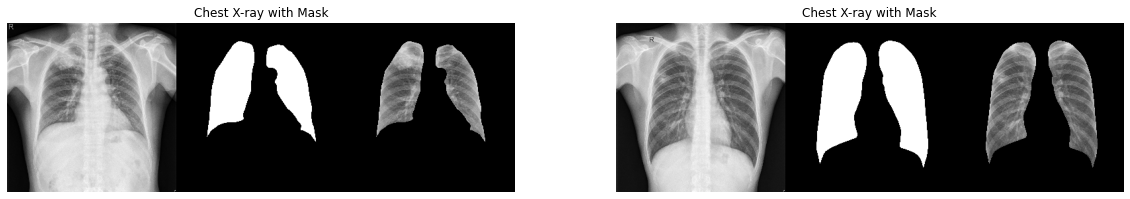

In [9]:
def plot_mask(X,y):
    i,j = np.random.randint(0,len(X),2)
    plt.figure(figsize=(20,20))
    
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Chest X-ray with Mask')
    plt.imshow(np.hstack((X[i],y[i],X[i]*y[i])), cmap = 'gray')
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Chest X-ray with Mask')
    plt.imshow(np.hstack((X[j],y[j],X[j]*y[j])), cmap = 'gray')
    
plot_mask(X,y)

The images are greyscale values, while the masks are binary.

The images are Xrays of the chest, while the masks are of the lungs, with rather smooth curvatures. 

The Xrays have the R and L annotation.

###  Create U-net model

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *

In [11]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [52]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [53]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=1*1e-5), loss= 'binary_crossentropy', metrics=[dice_coef])


### Callbacks

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

best_model_weights = './base.model2'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq="epoch"
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=7,
    verbose=2,
    mode='min'
)
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,earlystop,reduce]

### Train Model

In [55]:
EPOCHS = 40
batch_size = 32
validation_spit = 0.2
history = model.fit(x = X, 
                    y = y, 
                    validation_split = validation_spit, 
                    epochs = EPOCHS, 
                    batch_size = batch_size,
                    callbacks = callbacks )

Epoch 1/40
18/18 [==============================] - 8s 376ms/step - loss: 0.7086 - dice_coef: 0.3373 - val_loss: 0.7021 - val_dice_coef: 0.3386

Epoch 00001: val_loss improved from inf to 0.70213, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 2/40
18/18 [==============================] - 6s 333ms/step - loss: 0.6998 - dice_coef: 0.3361 - val_loss: 0.6947 - val_dice_coef: 0.3381

Epoch 00002: val_loss improved from 0.70213 to 0.69465, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 3/40
18/18 [==============================] - 6s 314ms/step - loss: 0.6907 - dice_coef: 0.3348 - val_loss: 0.6868 - val_dice_coef: 0.3376

Epoch 00003: val_loss improved from 0.69465 to 0.68681, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 4/40
18/18 [==============================] - 6s 315ms/step - loss: 0.6810 - dice_coef: 0.3330 - val_loss: 0.6781 - val_dice_coef: 0.3373

In [65]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')

    ax[1].set_title('Dice')
    ax[1].plot(history.epoch, history.history["dice_coef"], label="Train dice_coef")
    ax[1].plot(history.epoch, history.history["val_dice_coef"], label="Validation dice_coef")
    ax[1].set_ylabel('Dice')
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()

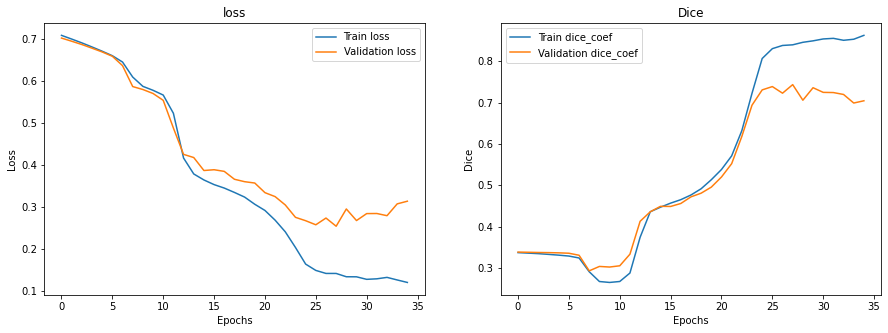

In [66]:
show_final_history(history)

Learning is successful, but shows a little underfitting.

### Load test data

In [58]:
test_dir = 'C:/Users/mifab/Documents/Git/Python_DS_Projects/CompVis/Lung Segmentation/test/*'
test_img = glob(test_dir)

In [59]:
def add_mask(img,mask):
    _ , mask = cv2.threshold(mask ,0.3,1,cv2.THRESH_BINARY)
    merged = img * mask.astype(np.float64)
    return merged    

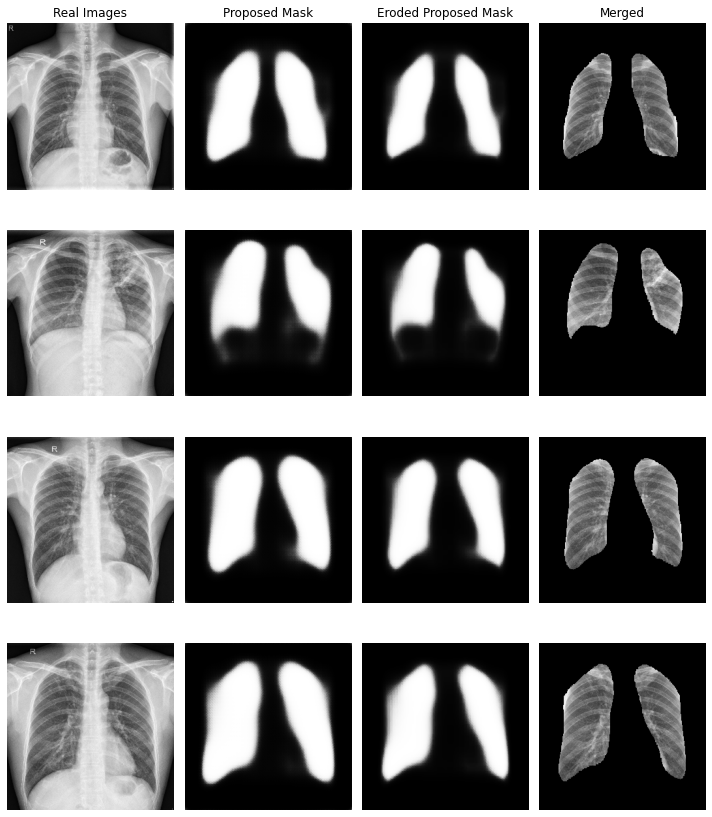

In [60]:
def plot_test(test_img,
              kernel =np.ones((5, 5),
                              np.uint8),
              save = False):
    size = 4
    test_size = len(test_img)
    test_sample = np.array(test_img)[np.random.randint(0, test_size, size).astype(int)]
    fig, axs = plt.subplots(nrows=size, ncols=4, figsize=(10, 12))
    cols = ['Real Images', 'Proposed Mask', 'Eroded Proposed Mask', 'Merged']
    
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
        
        
    axs = axs.ravel()
    
    for i in range(16):

        if i %4 == 0:
            
            img = cv2.imread(test_sample[i//4])
            img = transform_img(img)
            axs[i].imshow(img, cmap = 'gray')

        elif i %4 == 1:
            mask = model.predict(np.array([img]))
            axs[i].imshow(mask[0], cmap = 'gray')
        
        elif i %4 == 2:         
             erode_img = cv2.erode(mask[0], kernel, iterations=2) 
             axs[i].imshow(erode_img, cmap = 'gray')
        else:
             merged = add_mask(img, erode_img)
             axs[i].imshow(merged, cmap = 'gray')
        axs[i].axis('off')

    if save:
        plt.savefig('predicted_mask.jpeg')
    fig.tight_layout()
    plt.show()

kernel =  kernel =np.ones((5, 5), np.uint8)
plot_test(test_img, save =False)

### Conclusion

Good masks for segmentation have been achived via the use of UNET with dice.

The dice score could be further improved with some data augmentation and improving the vanilla Unet with resblocks.